In [4]:
# perform the necessary imports here
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

%matplotlib inline
pd.options.mode.chained_assignment = None

In [5]:
# read data into a dataframe
df = pd.read_csv('data/loan.csv', low_memory=False)

In [6]:
# drop columns that have 80% or more missing values and assign it to a new dataframe
df1 = df.dropna(axis=1, thresh=int(0.80*len(df))).copy()

In [7]:
# drop the following collumns
df1.drop(['id', 'member_id', 'policy_code', 'url', 'zip_code', 'last_pymnt_d'], axis=1, inplace=True)

In [8]:
# exract the year and month values from issue_f feature
df1['issue_month'], df1['issue_year'] = df1['issue_d'].str.split('-', 1).str

In [9]:
df1.dropna(axis=0, inplace=True)

In [10]:
# the loan status categories to be coverted to bad loan
bad_loan = ['Charged Off', 'Default', 'Late (16-30 days)','Late (31-120 days)']

def convert_loan_status(status):
    """This function converts the loan status feature into good or bad loan"""
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'

# apply the function above to the "loan_status" feature
df1['loan_status'] = df1['loan_status'].apply(convert_loan_status)

In [11]:
df1['loan_status'] = df1['loan_status'].astype('category').cat.codes

# print the number of good and bad loans
df1.loan_status.value_counts()

1    722589
0     46539
Name: loan_status, dtype: int64

In [12]:
# features to be dropped
df1.drop(['emp_title', 'issue_d', 'title', 'addr_state', 
          'earliest_cr_line', 'last_credit_pull_d', 'funded_amnt',
          'funded_amnt_inv', 'sub_grade','total_rec_prncp', 
          'total_rev_hi_lim', 'issue_month', 'issue_year',
          'term', 'verification_status'], axis=1, inplace=True)

In [13]:
df1 = pd.get_dummies(df1, drop_first=True)

In [35]:
# Create arrays for the features and the response variable
y = df1['loan_status']
X = df1.drop('loan_status', axis=1)

In [36]:
# Splitting the dataset in training (75%) and testing set (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=y)

In [37]:
scaler = StandardScaler()
numeric_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')].to_list()
scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])

In [38]:
numeric_cols = X_test.columns[(X_test.dtypes == 'float64') | (X_test.dtypes == 'int64')].to_list()
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [39]:
y_train.value_counts()

1    541942
0     34904
Name: loan_status, dtype: int64

In [40]:
sm = SMOTE(random_state=27, sampling_strategy={1:541942, 0:300000})
X_train, y_train = sm.fit_sample(X_train, y_train)

In [41]:
y_train.value_counts()

1    541942
0    300000
Name: loan_status, dtype: int64

In [42]:
y_test.value_counts()

1    180647
0     11635
Name: loan_status, dtype: int64

In [46]:
# instantiate Random Forest Classifier
ranfor = RandomForestClassifier(n_estimators=3)

# Fit it to the data
ranfor.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = ranfor.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[  8260   3375]
 [  3633 177014]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70     11635
           1       0.98      0.98      0.98    180647

    accuracy                           0.96    192282
   macro avg       0.84      0.84      0.84    192282
weighted avg       0.96      0.96      0.96    192282



Text(0.5, 0, 'Relative Importance')

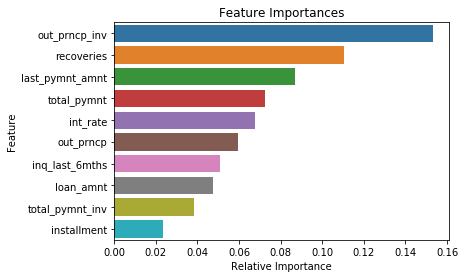

In [30]:
features = X_train.columns
importances = ranfor.feature_importances_
df = pd.DataFrame({'Feature': features, 'Importance': importances})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

In [45]:
# instantiate a Decision Tree classifier
tree = DecisionTreeClassifier()

# Fit it to the data
tree.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = ranfor.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[  8289   3346]
 [  3889 176758]]
              precision    recall  f1-score   support

           0       0.68      0.71      0.70     11635
           1       0.98      0.98      0.98    180647

    accuracy                           0.96    192282
   macro avg       0.83      0.85      0.84    192282
weighted avg       0.96      0.96      0.96    192282



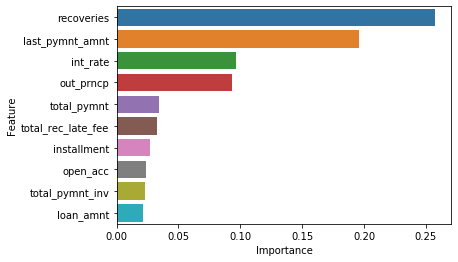

In [32]:
feat = X_train.columns
imp = tree.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);

In [47]:
# instantiate Logistic Regression
logreg = LogisticRegression(max_iter=1000)

# Fit it to the data
logreg.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# generate the classification report
print(classification_report(y_test, y_pred))

[[  8257   3378]
 [  3113 177534]]
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     11635
           1       0.98      0.98      0.98    180647

    accuracy                           0.97    192282
   macro avg       0.85      0.85      0.85    192282
weighted avg       0.97      0.97      0.97    192282

